## Train a cellpose 2D model 

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [8]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path
from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [9]:
tnia_images_path = Path(r"D:\images")
parent_path = r'D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2'

train_path = os.path.join(parent_path, 'patches')
#train_path = os.path.join(parent_path, 'labels')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [10]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=True)


print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 1200
Number of ground truth images  1200
Size of first input image (512, 512, 3)
Size of first ground truth image  (512, 512)


## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [11]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 200, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))


Number of training images 1000
Number of validaiton images  200


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(512, 512, 3) (512, 512)
0.0 1.0
float32 (512, 512, 3) 0.0 1.0


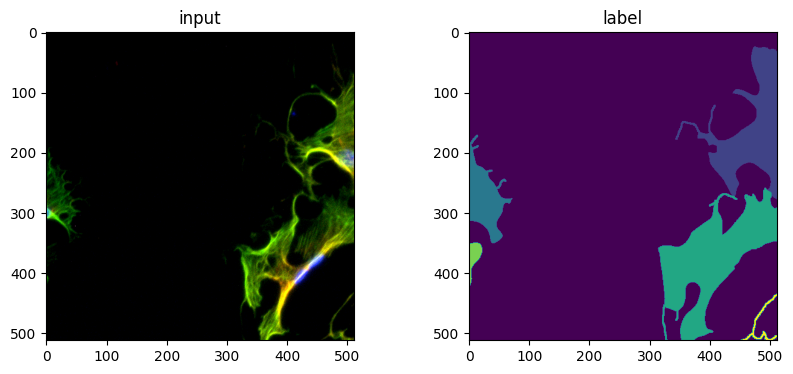

In [12]:
n=0
X_ = X_train[n]
Y_ = Y_train[n]

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create a cellpose model

In [13]:
import os

model_name = 'cellpose_testing_tnia_augment_color_norm'

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL
model= models.CellposeModel(gpu=True, pretrained_model=os.path.join(model_path,'models',model_name))
#model= models.CellposeModel(gpu=True, pretrained_model=None) #os.path.join(model_path,'models',model_name))

creating new log file
2024-10-20 17:18:29,421 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-10-20 17:18:29,422 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118
2024-10-20 17:18:31,085 [INFO] ** TORCH CUDA version installed and working. **
2024-10-20 17:18:31,087 [INFO] >>>> using GPU
2024-10-20 17:18:31,185 [INFO] >>>> loading model D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_augment_color_norm
2024-10-20 17:18:31,265 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-20 17:18:31,267 [INFO] >>>> model diam_labels =  60.485 (mean diameter of training ROIs)


# Train the model

In [14]:
from cellpose import train

new_model_path = train.train_seg(model.net, X_train, Y_train, test_data=X_val, test_labels=Y_val,  
                              channels=[2,3], 
                              save_path=model_path, 
                              n_epochs=50,
                              min_train_masks=0,
                              rescale = False,  
                              model_name=model_name,
                              normalize=False,
                              bsize=512)

2024-10-20 17:18:41,033 [INFO] computing flows for labels


100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]

2024-10-20 17:22:22,729 [INFO] computing flows for labels



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

2024-10-20 17:23:07,157 [INFO] >>> computing diameters



100%|██████████| 200/200 [00:00<00:00, 731.88it/s]

2024-10-20 17:23:08,779 [INFO] >>> using channels [2, 3]


2024-10-20 17:23:12,196 [INFO] >>> n_epochs=50, n_train=1000, n_test=200
2024-10-20 17:23:12,198 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-20 17:23:12,203 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\models\cellpose_testing_tnia_augment_color_norm
2024-10-20 17:24:33,549 [INFO] 0, train_loss=0.1843, test_loss=0.1926, LR=0.0000, time 81.35s
2024-10-20 17:30:58,121 [INFO] 5, train_loss=0.1674, test_loss=0.2114, LR=0.0028, time 465.92s
2024-10-20 17:37:33,715 [INFO] 10, train_loss=0.1778, test_loss=0.2190, LR=0.0050, time 861.51s
2024-10-20 17:50:14,698 [INFO] 20, train_loss=0.1765, test_loss=0.2341, LR=0.0050, time 1622.50s
2024-10-20 18:02:54,221 [INFO] 30, train_loss=0.1747, test_loss=0.1924, LR=0.0050, time 2382.02s
2024-10-20 18:15:33,712 [INFO] 40, train_loss=0.1725, test_loss=0.2178, LR=0.0050, time 3141.51s


## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

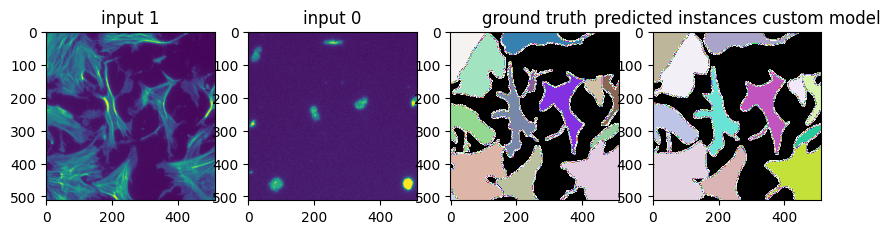

In [10]:
from tnia.plotting.plt_helper import random_label_cmap
# run model on test images
n=455
masks = model.eval(X_train[n], channels=[2,3], cellprob_threshold=-1, flow_threshold=0.4)
fig = imshow_multi2d([X_train[n][:,:,1], X_train[n][:,:,2], Y_train[n], masks[0]],['input 1','input 0', 'ground truth','predicted instances custom model'],1,4,colormaps=[None,None,random_label_cmap(),random_label_cmap()])


## View in Napari

In [12]:
import napari
import pandas as pd

points = pd.read_csv(parent_path / 'Results.csv')
viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels')
viewer.add_labels(labels_cyto2, name='labels_cyto2')
points_layer = viewer.add_points(points[['Y', 'X']], size=4, face_color='blue', name='points')

In [15]:
dir = r"D:\images\tnia-python-images\imagesc\2024_06_10_ladybugs\Archive"

files = os.listdir(dir)

In [16]:
len(files)

2301

In [20]:
files[0]

'10000827_13750024.jpg'